In [19]:
# ! pip3 install icevision
! pip install ipywidgets
! pip install --upgrade jupyter_client
! pip install jupyterlab_widgets

In [22]:
! conda install -y -c conda-forge ipywidgets
! jupyter nbextension enable --py widgetsnbextension

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/naziahsiddique/anaconda3/envs/fastaicourse

  added / updated specs:
    - ipywidgets


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bleach-3.3.1               |     pyhd8ed1ab_0         111 KB  conda-forge
    ipywidgets-7.6.3           |     pyhd3deb0d_0         101 KB  conda-forge
    jupyterlab_widgets-1.0.0   |     pyhd8ed1ab_1         130 KB  conda-forge
    pandoc-2.14.1              |       h0d85af4_0        15.3 MB  conda-forge
    python-dateutil-2.8.2      |     pyhd8ed1ab_0         240 KB  conda-forge
    widgetsnbextension-3.5.1   |   py38h50d1736_4         1.8 MB  conda-forge
    -----------------------------------------------

In [1]:
from icevision.all import *

In [2]:
! ls ..

README.md                       data                            end-to-end-model-training.ipynb master_notebook.ipynb           requirements.txt                tmp
Untitled.ipynb                  docs                            infer                           models                          src


In [3]:
# Location of the image root
data_dir = Path('../data/nikelogos')
print(data_dir)

../data/nikelogos


## Parse the dataset

The parser loads the annotation file and parses them returning a list of training and validation records. The parser has an extensible `autofix` capability that identifies common errors in annotation files, reports, and often corrects them automatically.

The parsers support multiple formats (including VOC and COCO). You can also extend the parser for additional formats if needed.

The record is a key concept in IceVision, it holds the information about an image and its annotations. It is extensible and can support other object formats and types of annotations.

In [4]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "annotations", images_dir=data_dir / "images")
parser.class_map

<ClassMap: {'background': 0}>

In [5]:
# Parse annotations to create records
train_records, valid_records = parser.parse()

  0%|          | 0/323 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

## Creating datasets with agumentations and transforms

Data augmentations are essential for robust training and results on many datasets and deep learning tasks. IceVision ships with the [Albumentations](https://albumentations.ai/docs/) library for defining and executing transformations, but can be extended to use others.

For this tutorial, we apply the Albumentation's default `aug_tfms` to the training set. `aug_tfms` randomly applies broadly useful transformations including rotation, cropping, horizintal flips, and more. See the Albumentations documentation to learn how to customize each transformation more fully.

The validation set is only resized (with padding).

We then create `Datasets` for both. The dataset applies the transforms to the annotations (such as bounding boxes) and images in the data records.

In [6]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize(), tfms.A.Rotate()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [7]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
print(valid_ds)
print(train_ds)

<Dataset with 65 items>
<Dataset with 258 items>


### Understanding the transforms

The Dataset transforms are only applied when we grab (get) an item. Several of the default `aug_tfms` have a random element to them. For example, one might perform a rotation with probability 0.5 where the angle of rotation  is randomly selected between +45 and -45 degrees.

This means that the learner sees a slightly different version of an image each time it is accessed. This effectively increases the size of the dataset and improves learning.

We can look at result of getting the 0th image from the dataset a few times and see the differences. Each time you run the next cell, you will see different results due to the random element in applying transformations.

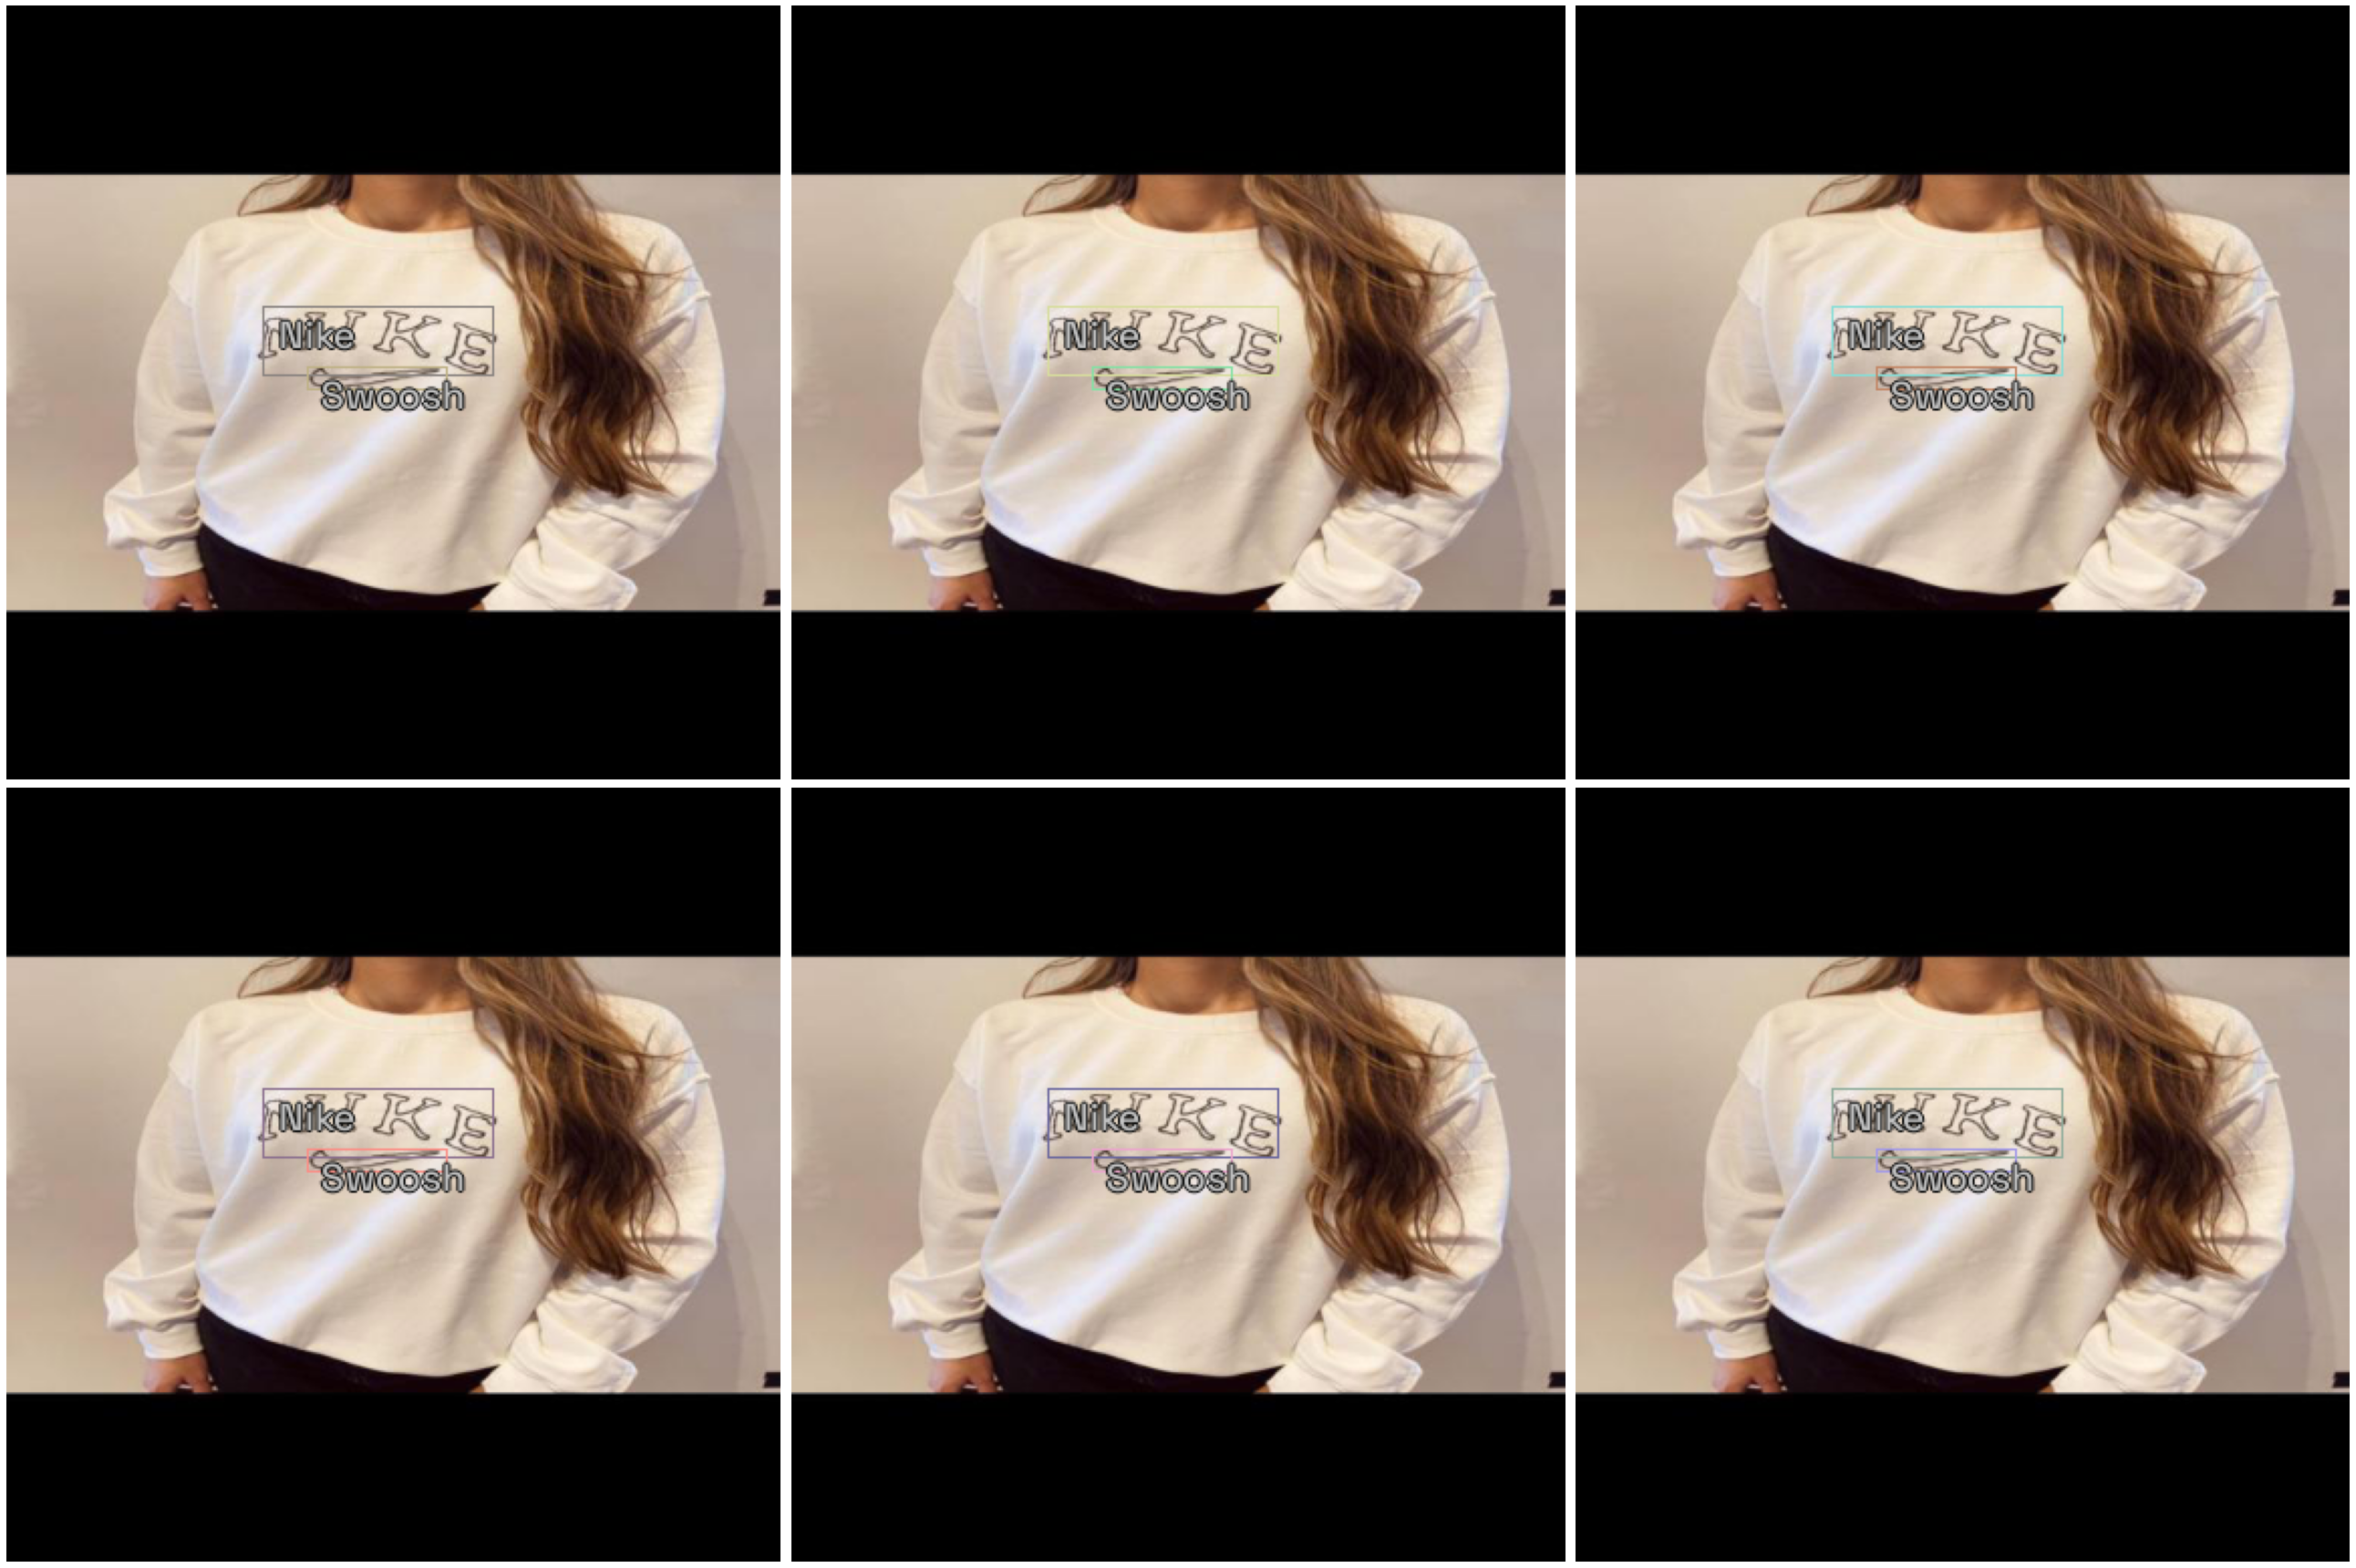

In [8]:
# Show an element of the train_ds with augmentation transformations applied
samples = [valid_ds[0] for _ in range(6)]
show_samples(samples, ncols=3)


## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.

### Creating a model
Selections only take two simple lines of code. For example, to try the mmdet library using the retinanet model and the resnet50_fpn_1x backbone  could be specified by:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.

In [9]:
# Just change the value of selection to try another model

selection = 1


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.torchvision.retinanet' from '/Users/naziahsiddique/anaconda3/envs/fastaicourse/lib/python3.8/site-packages/icevision/models/torchvision/retinanet/__init__.py'>,
 {})

Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [10]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/naziahsiddique/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [11]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [12]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

RuntimeError: DataLoader worker (pid(s) 1770, 1771, 1772) exited unexpectedly

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning). 

### Find Learning Rate

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [ ]:
learn.lr_find()

# Train Model

In [ ]:
# learn.fine_tune(40, 1e-4, freeze_epochs=1)
num_epochs = 100
learn.fine_tune(num_epochs, 1e-3, freeze_epochs=1)

# Save Model Outputs

In [ ]:
PATH = f"nikemodel_model_{selection}_new_{num_epochs}.mm"
torch.save(model.state_dict(), PATH)


# Load Model Outputs

In [ ]:
model.load_state_dict(torch.load(PATH))
# model.eval()

In [ ]:
import PIL
img_path = "image1.jpeg"
# img_path = "nike_female_jumper.png"
# img_path = "image_2.jpg"
img = PIL.Image.open(img_path)
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])
infer_ds = Dataset.from_images([img], infer_tfms)

preds = model_type.predict(model, infer_ds, keep_images=True)
for x in preds[0].pred.detection.components:
    print(x)
    if 'ScoresRecordComponent' in str(x):
        scores = x.scores
        print(scores)
    if 'InstancesLabelsRecordComponent' in str(x):
        labels = x.label_ids
        print(labels)
    if 'BBoxesRecordComponen' in str(x):
        bboxes = x.bboxes
        print(bboxes)
        
show_preds(preds=preds[0:1])